Holy Quran preprocesser

This model will take the Holy Quran text in arabic and english and transform it into a clean text using different tools. After that a machine learning model will be used to train a model that when taking an input word it will print the associated word with it.

In [64]:
import gensim
import re
from gensim import models
import numpy as np
from nltk.stem.isri import ISRIStemmer
from urllib import request 
from bs4 import BeautifulSoup as bs
import nltk 
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn import cluster
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud
from gensim.models import Word2Vec
import matplotlib.pyplot as plt 
import pandas as pd

Word Embedding is the process of taking a words or a phrases from the vocabulary which are mapped to vectors of real numbers.
So, we will use this concept on the holy quran dataset. the idea is to capture as much information as possible


Load the dataset to be used. the use of arabic and english holy quran text

In [65]:
# Load Quran from csv into a dataframe
quran = pd.read_csv('ao.csv', sep='|', header='infer')

First, we will remove the harakat (tashkeel) from the arabic text.

In [66]:
quran['verse_W_O_H'] = quran['verse'].map(lambda x: re.sub('[ًٌٍَُِّۙ~ْۖۗ]', '', x))
quran.head()

,surah,ayah,verse,verse_W_O_H
0,1,1,بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ,بسم الله الرحمٰن الرحيم
1,1,2,الْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ,الحمد لله رب العالمين
2,1,3,الرَّحْمَٰنِ الرَّحِيمِ,الرحمٰن الرحيم
3,1,4,مَالِكِ يَوْمِ الدِّينِ,مالك يوم الدين
4,1,5,إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ,إياك نعبد وإياك نستعين


Tokenize
this will divide phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. 

In [67]:
#Arabic text tokenizer 
quran['Toknverse'] = quran['verse_W_O_H'].str.split()
quran.head()


,surah,ayah,verse,verse_W_O_H,Toknverse
0,1,1,بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ,بسم الله الرحمٰن الرحيم,"[بسم, الله, الرحمٰن, الرحيم]"
1,1,2,الْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ,الحمد لله رب العالمين,"[الحمد, لله, رب, العالمين]"
2,1,3,الرَّحْمَٰنِ الرَّحِيمِ,الرحمٰن الرحيم,"[الرحمٰن, الرحيم]"
3,1,4,مَالِكِ يَوْمِ الدِّينِ,مالك يوم الدين,"[مالك, يوم, الدين]"
4,1,5,إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ,إياك نعبد وإياك نستعين,"[إياك, نعبد, وإياك, نستعين]"


Third, will remove the Arabic stop words from the text.

In [68]:
nltk.download('stopwords')
# Extract Arabic stop words
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
# Remove Arabic stop words
quran['A-S-verse'] = quran['Toknverse'].map(lambda x: [w for w in x if w not in arb_stopwords])
quran['cleanT'] = quran['A-S-verse'].apply(lambda i : ' '.join(i))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rsn01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Apply arabic stemmer

In [69]:
# Initialize Arabic stemmer
st = ISRIStemmer()
# Exclude these words from the stemmer
stem_not = ['الله', 'لله', 'إلهكم', 'اله', 'لله', 'إلهكم', 'إله', 'بالله', 'ولله']
#%%

quran['St-verse'] = quran['A-S-verse'].map(lambda x: [w if w in stem_not else st.stem(w) for w in x])

In [70]:
quran.head()

,surah,ayah,verse,verse_W_O_H,Toknverse,A-S-verse,cleanT,St-verse
0,1,1,بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ,بسم الله الرحمٰن الرحيم,"[بسم, الله, الرحمٰن, الرحيم]","[بسم, الله, الرحمٰن, الرحيم]",بسم الله الرحمٰن الرحيم,"[بسم, الله, رحمٰ, رحم]"
1,1,2,الْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ,الحمد لله رب العالمين,"[الحمد, لله, رب, العالمين]","[الحمد, لله, رب, العالمين]",الحمد لله رب العالمين,"[حمد, لله, رب, علم]"
2,1,3,الرَّحْمَٰنِ الرَّحِيمِ,الرحمٰن الرحيم,"[الرحمٰن, الرحيم]","[الرحمٰن, الرحيم]",الرحمٰن الرحيم,"[رحمٰ, رحم]"
3,1,4,مَالِكِ يَوْمِ الدِّينِ,مالك يوم الدين,"[مالك, يوم, الدين]","[مالك, يوم, الدين]",مالك يوم الدين,"[الك, يوم, دين]"
4,1,5,إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ,إياك نعبد وإياك نستعين,"[إياك, نعبد, وإياك, نستعين]","[نعبد, وإياك, نستعين]",نعبد وإياك نستعين,"[عبد, وإا, ستع]"


We will use word2vec model which will train our model. word2vec is a model that uses neural networks to learn word association. each word is represented as a vector.
word2vec has 2 training algorithms:
continuous bag-of-words (CBOW) or continuous skip-gram. 
In the CBOW architecture, the model predicts the current word from a window of surrounding context words. The order of context words does not influence prediction (bag-of-words assumption). 
In the continuous skip-gram architecture, the model uses the current word to predict the surrounding window of context words. The skip-gram architecture weighs nearby context words more heavily than more distant context words.


To start visulize the words we need to use a word cloud which will print the words depending of their frequncy. To do that we need to define some functions to do that. one will be to generate the word cloud and the other will be using our defined model to print the cloud.

In [71]:
def print_word_cloud_ar(artext_list, word_frequency):
    """Takes a list of Arabic words to print cloud."""
    full_string = ' '.join(artext_list)
    reshaped_text = arabic_reshaper.reshape(full_string)
    artext = get_display(reshaped_text)
    
    # Build the Arabic word cloud
    wordc = WordCloud(font_path='tahoma',background_color='white',width=2000,height=2000).generate(artext)
    wordc.fit_words(word_frequency)
    
    # Draw the word cloud
    plt.imshow(wordc)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

In [72]:
def print_similar_word_cloud(one_word, topn, model):
    """Takes an Arabic word and print similar word cloud for top number of words {$topn}."""
    temp_tuple=model.wv.most_similar(positive=[one_word], negative=[], topn=topn)
    similar_words=[i[0] for i in temp_tuple]
    word_frequency = {}
    for word_tuple in temp_tuple:
        reshaped_word = arabic_reshaper.reshape(word_tuple[0])
        key = get_display(reshaped_word)
        word_frequency[key] = word_tuple[1]
    print(temp_tuple)
    
    print_word_cloud_ar(similar_words, word_frequency)

now will be the testing of the model.

[('لبني', 0.7321415543556213), ('آتينا', 0.7041438817977905), ('مرية', 0.6410092711448669), ('وآتينا', 0.6162005066871643), ('إسرائيل', 0.6006540656089783), ('داوود', 0.5939731001853943), ('وموعظة', 0.5822334289550781), ('فأرسل', 0.5785764455795288), ('سبقت', 0.575866162776947), ('فاحكم', 0.570037841796875), ('هدى', 0.5640438199043274), ('بني', 0.5621024966239929), ('نبيا', 0.5599480867385864), ('ظهورهم', 0.559468686580658), ('ولقد', 0.5582671165466309), ('جانب', 0.5511237382888794), ('لسان', 0.5456326007843018), ('بآية', 0.5408524870872498), ('الطيبات', 0.5289088487625122), ('النبيين', 0.5107482671737671), ('بصائر', 0.5075650215148926), ('الطور', 0.5071703791618347), ('واذكر', 0.5067358016967773), ('لقضي', 0.5023585557937622), ('الآخرين', 0.5020062923431396), ('الطعام', 0.5014362335205078), ('أخذنا', 0.49538612365722656), ('أوحينا', 0.4922064542770386), ('رسلا', 0.49094241857528687), ('نعلم', 0.4877365231513977), ('ادع', 0.4869318902492523), ('آثارهم', 0.48633354902267456), ('وهدى', 0

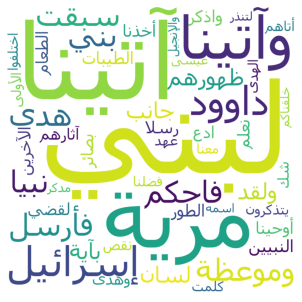

In [73]:
ARSmodel= Word2Vec(quran['A-S-verse'], min_count=5, window=7, workers=8, alpha=0.07, sg=1, hs=1)
wordo = "موسى"
print_similar_word_cloud(wordo, 50, ARSmodel)

[('إبليس', 0.7723473310470581), ('القرون', 0.7229101657867432), ('قلنا', 0.7158950567245483), ('رسلنا', 0.7135941982269287), ('فبما', 0.7045223712921143), ('خلت', 0.7035922408103943), ('فكذبوه', 0.7007706165313721), ('صدق', 0.6904342770576477), ('نذير', 0.689177930355072), ('أوحينا', 0.6846489906311035), ('حكما', 0.6825355291366577), ('ونحن', 0.6740436553955078), ('أهلكنا', 0.6733779311180115), ('بلغ', 0.6718957424163818), ('رسل', 0.6621355414390564), ('نزل', 0.6614904403686523), ('الطور', 0.6607939004898071), ('سلطان', 0.6604086756706238), ('فاصبر', 0.6553509831428528), ('المنذرين', 0.6512484550476074), ('عبد', 0.6500868201255798), ('اسجدوا', 0.6489152312278748), ('فأرسلنا', 0.6464796662330627), ('رسولا', 0.6403090953826904), ('يأتكم', 0.6365775465965271), ('علمتم', 0.6335916519165039), ('لتنذر', 0.632960855960846), ('يحيىٰ', 0.6311018466949463), ('رأىٰ', 0.629010021686554), ('والطير', 0.6289008855819702), ('وتولىٰ', 0.6247921586036682), ('أنه', 0.6238469481468201), ('قرية', 0.6229865

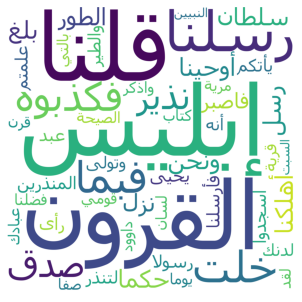

In [74]:
ARSmodelc= Word2Vec(quran['A-S-verse'], min_count=5, window=7, workers=8, alpha=0.07, sg=0, hs=1)
wordo = "موسى"
print_similar_word_cloud(wordo, 50, ARSmodelc)

[('آتينا', 0.9644876718521118), ('وآتينا', 0.9222230315208435), ('لبني', 0.920609712600708), ('رسلا', 0.9013471603393555), ('نبيا', 0.8958290815353394), ('يتذكرون', 0.8910253047943115), ('أتاهم', 0.8833696246147156), ('مدكر', 0.8805485367774963), ('مرية', 0.8767974972724915), ('بآية', 0.8738905191421509), ('ولقد', 0.8730058670043945), ('بعده', 0.8719108700752258), ('للذكر', 0.8671544194221497), ('وفرعون', 0.8601981997489929), ('يتلو', 0.8534643054008484), ('حديث', 0.8533228635787964), ('لتنذر', 0.8525194525718689), ('وموعظة', 0.8525159358978271), ('الطعام', 0.849738359451294), ('معنا', 0.8465185761451721), ('قومهم', 0.8461311459541321), ('أوحينا', 0.845772922039032), ('مريب', 0.8441572785377502), ('وهارون', 0.8437410593032837), ('أخذنا', 0.8426237106323242), ('شك', 0.8360773921012878), ('ووهبنا', 0.8343141078948975), ('وموسىٰ', 0.8323937058448792), ('قبلك', 0.8317142724990845), ('الأولىٰ', 0.8305799961090088), ('فأرسل', 0.8303254842758179), ('بعثنا', 0.8285696506500244), ('نقص', 0.8284

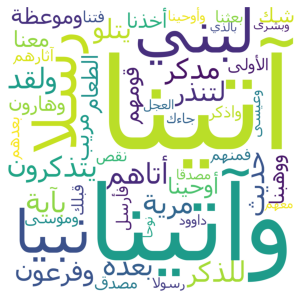

In [80]:
ARSmodelneg= Word2Vec(quran['A-S-verse'], min_count=5, window=7, workers=8, alpha=0.07, sg=1, hs=0)
wordo = "موسى"
print_similar_word_cloud(wordo, 50, ARSmodelneg)

Now we strat working with english text

In [75]:
qurane = pd.read_csv('quran-en-ar-place.csv', header=None)

In [76]:
qurane['Toknverse'] = qurane[5].str.split()
nltk.download('stopwords')
# Extract English stop words
eng_stopwords = set(nltk.corpus.stopwords.words("english"))
# Remove English stop words
qurane['A-S-verse'] = qurane['Toknverse'].map(lambda x: [w for w in x if w not in eng_stopwords])
qurane['cleanT'] = qurane['A-S-verse'].apply(lambda i : ' '.join(i))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rsn01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
qurane.head()

,0,1,2,3,4,5,6,7,Toknverse,A-S-verse,cleanT
0,sno,SrNo,vno,Ayah,words,en,wc,Place,[en],[en],en
1,1,0,1,بسم الله الرحمن الرحيم,4,"In the name of Allah, Most Gracious, Most Merc...",4,Meccan,"[In, the, name, of, Allah,, Most, Gracious,, M...","[In, name, Allah,, Most, Gracious,, Most, Merc...","In name Allah, Most Gracious, Most Merciful."
2,1,1,2,الحمد لله رب العالمين,4,"Praise be to Allah, the Cherisher and Sustaine...",4,Meccan,"[Praise, be, to, Allah,, the, Cherisher, and, ...","[Praise, Allah,, Cherisher, Sustainer, worlds;]","Praise Allah, Cherisher Sustainer worlds;"
3,1,2,3,الرحمن الرحيم,2,"Most Gracious, Most Merciful;",2,Meccan,"[Most, Gracious,, Most, Merciful;]","[Most, Gracious,, Most, Merciful;]","Most Gracious, Most Merciful;"
4,1,3,4,مالك يوم الدين,3,Master of the Day of Judgment.,3,Meccan,"[Master, of, the, Day, of, Judgment.]","[Master, Day, Judgment.]",Master Day Judgment.


[('Aaron', 0.6486479043960571), ('Aaron,', 0.6204611659049988), ('"Strike', 0.5692204833030701), ('people:', 0.5520848631858826), ('Lut,', 0.5079647898674011), ('Ark', 0.49769315123558044), ('transgressed', 0.4871616065502167), ('caravan', 0.4848078787326813), ('Mount', 0.47636741399765015), ("Shu'aib", 0.4755813777446747), ('Moses,', 0.4754454493522644), ('"Behold!', 0.4719756543636322), ('manifest,', 0.4719651937484741), ('Joseph,', 0.46994686126708984), ('sorcerer', 0.4696587324142456), ('(was', 0.4640074372291565), ('(Allah)?', 0.4632776379585266), ('brother', 0.46278977394104004), ('prophet.', 0.4560800790786743), ('Adam', 0.45598214864730835), ('"Will', 0.4554126262664795), ('Behold,', 0.45260393619537354), ('burning', 0.45251989364624023), ('Noah', 0.44476550817489624), ('Jacob,', 0.4430316984653473), ('prayed:', 0.4422357678413391), ('water.', 0.44205453991889954), ('Pharaoh,', 0.44156965613365173), ('Pharaoh:', 0.4411736726760864), ('sorcerers', 0.4351339638233185), ("Isma'il,

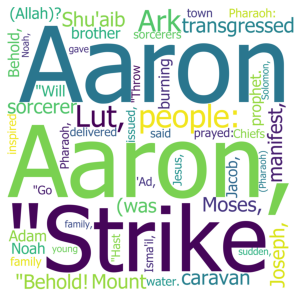

In [78]:
ARSmodele= Word2Vec(qurane['A-S-verse'], min_count=5, window=7, workers=8, alpha=0.07, sg=1, hs=1)
wordo = "Moses"
print_similar_word_cloud(wordo, 50, ARSmodele)

[('began', 0.7369788289070129), ('presence,', 0.7229664921760559), ('Lut', 0.6952372789382935), ('brother', 0.6937021017074585), ('saw', 0.6911056041717529), ('until,', 0.6884381175041199), ('suffering', 0.6874377131462097), ('Pharaoh:', 0.682548463344574), ('him:', 0.6789644956588745), ("Isma'il,", 0.6763388514518738), ('rising', 0.6653268337249756), ('disputed', 0.6552116870880127), ('came', 0.6482498645782471), ('Aaron', 0.6457378268241882), ('"Fear', 0.6444790959358215), ('him,', 0.639918327331543), ('Behold,', 0.6376716494560242), ('down,', 0.6239089369773865), ('delivered', 0.6233178377151489), ('example', 0.6223772168159485), ('earth),', 0.6210872530937195), ('plotting', 0.6178509593009949), ('(We', 0.6166723966598511), ('entered', 0.6151561141014099), ('took', 0.6114598512649536), ('bones', 0.6101308465003967), ('Noah', 0.6096628904342651), ('conceived', 0.6088498830795288), ('Jesus', 0.6051733493804932), ('"Go', 0.6020091772079468), ('overwhelmed', 0.599415123462677), ('warnin

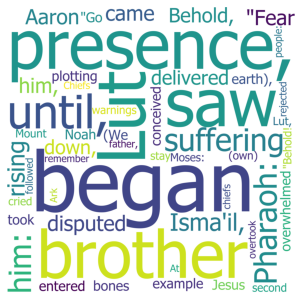

In [79]:
ARSmodelec= Word2Vec(qurane['A-S-verse'], min_count=5, window=7, workers=8, alpha=0.07, sg=0, hs=1)
wordo = "Moses"
print_similar_word_cloud(wordo, 50, ARSmodelec)